## Fornberg Stencil Tester

In [1]:
import numpy as np
import pandas as pd


from average_atom.core.average_atom import NeutralPseudoAtom as NPA
from average_atom.core.misc import jacobi_relaxation, sor
from average_atom.core.grids import NonUniformGrid
from average_atom.core.physics import ThomasFermi, FermiDirac

from importlib import reload
try:
    reload(physics)
    reload(grids)
    reload(average_atom_geometric)
#     reload(average_atom)
    reload(misc)
except NameError as e:
    from average_atom.core import physics as physics
    from average_atom.core import average_atom as average_atom
    from average_atom.core import misc as misc
    from average_atom.core import grids as grids
    print("Error: ",e)
except Exception as e:
    print("Unexpected error during reload")
    print(e)

import matplotlib.pyplot as plt

from hnc.hnc.constants import *
from hnc.hnc.misc import rs_from_n, n_from_rs

import cProfile

plt.rcParams.update({'font.size': 10})
plt.rcParams["figure.figsize"] = (5,3.5)
plt.rcParams["figure.dpi"] = 200
plt.rcParams['xtick.labelsize']=14


color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']



Error:  name 'physics' is not defined


### Create Grid for testing

In [16]:
name = 'C'
Z, A = 6, 12.011

Ti_eV = 0.5 
Te_eV = 0.5

Te_AU = Te_eV*eV_to_AU
Ti_AU = Ti_eV*eV_to_AU

rs = 1

####
R = 10*rs
rmin = rs/1000
ignore_vxc = True
fixed_Zstar = False

npa_kwargs = {'initialize':True, 'gradient_correction':None,'μ_init' : 0.158, 'Zstar_init' : 'More', 'rmin':1e-3 ,'Npoints':1000, 
              'name':name,'ignore_vxc':ignore_vxc, 'fixed_Zstar':fixed_Zstar, 'iet_R_over_rs':R/rs, 'iet_N_bins':10000, 'use_full_ne_for_nf':False,
             'gii_init_type': 'step', 'grid_spacing':'geometric'}

## Plotting function for comparing two quantities

In [17]:
def compare_over_grid(v1, v2):
    # Create a figure and a set of subplots with shared x-axis
    fig, axs = plt.subplots(2, 1, sharex='col')

    # Plotting v1 and v2 on the first subplot
    axs[0].plot(npa.grid.xs, v1, '--.', label='v1', zorder=10, markersize=3)
    axs[0].plot(npa.grid.xs, v2, '--.', label='v2')
    axs[0].set_yscale('symlog', linthresh=1e-3)  # Set y-axis to symlog scale
    axs[0].set_xscale('log')  # Set x-axis to log scale
    axs[0].legend()  # Add legend to the plot

    # Calculating relative error and plotting on the second subplot
    relative_error = np.abs(2*(v1 - v2))# / v2 )
    axs[1].plot(npa.grid.xs, relative_error, '--.', color='red', markersize=2, linewidth=1)
    axs[1].set_yscale('log')  # Set y-axis to log scale
    axs[1].set_ylabel('Absolute Error')  # Label y-axis
    axs[1].set_ylim(1e-14, 100)
    
    # Set common labels and title
    plt.xlabel('x [au]')  # Label x-axis
    plt.subplots_adjust(hspace=0.1)  # Adjust the space between plots
    plt.show()


In [18]:
npa_kwargs.update({'N_stencil_oneside':2})
npa = NPA(Z, A, Ti_AU, Te_AU, rs, R, **npa_kwargs)

________________________
Generating NPA
Using More TF fit for initial Zstar = 3.703
	Intializing grid
	Creating Integral Equation Solver
Intialized Potentials and Densities


##### Create charge density to check against

In [19]:
λ = 1
ρ = λ**-3/(8*π)/( 1  - np.exp(-R/λ)*(R/λ*(R/λ+2)/2 + 1 )) * np.exp(-npa.grid.xs/λ)
ρ = np.exp(-npa.grid.xs/λ)
dρdx = -ρ/λ
d2ρdx2 = ρ/λ**2
laplace_ρ = 2/npa.grid.xs * dρdx + d2ρdx2  # laplace ρ = 1/r^2 d/dr(  r^2 d/dr ρ) = 2/r dρ/dr + d^2/dr^2 ρ

________________________
Generating NPA
Using More TF fit for initial Zstar = 3.703
	Intializing grid
	Creating Integral Equation Solver
Intialized Potentials and Densities


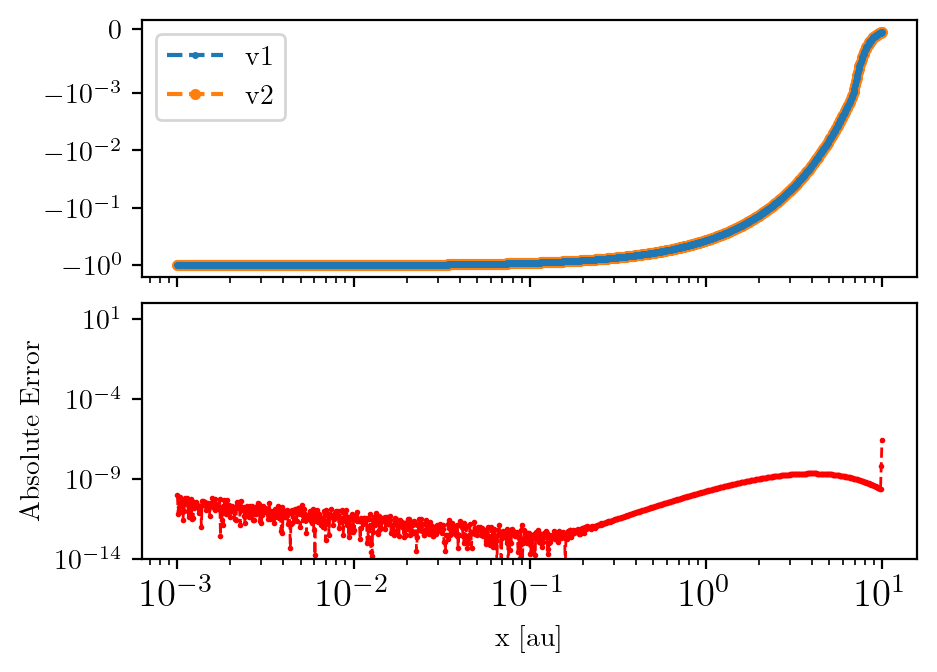

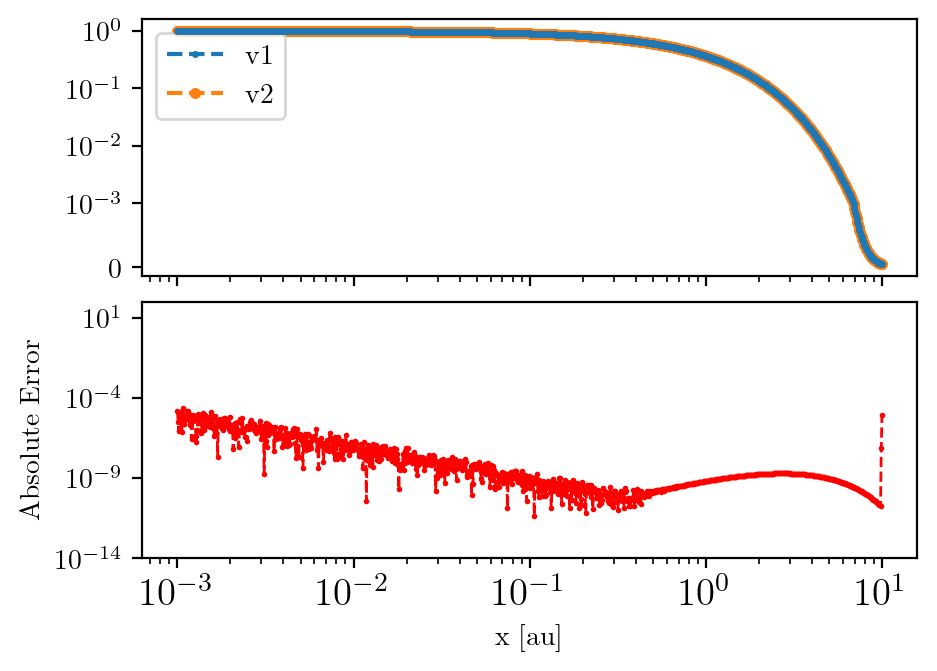

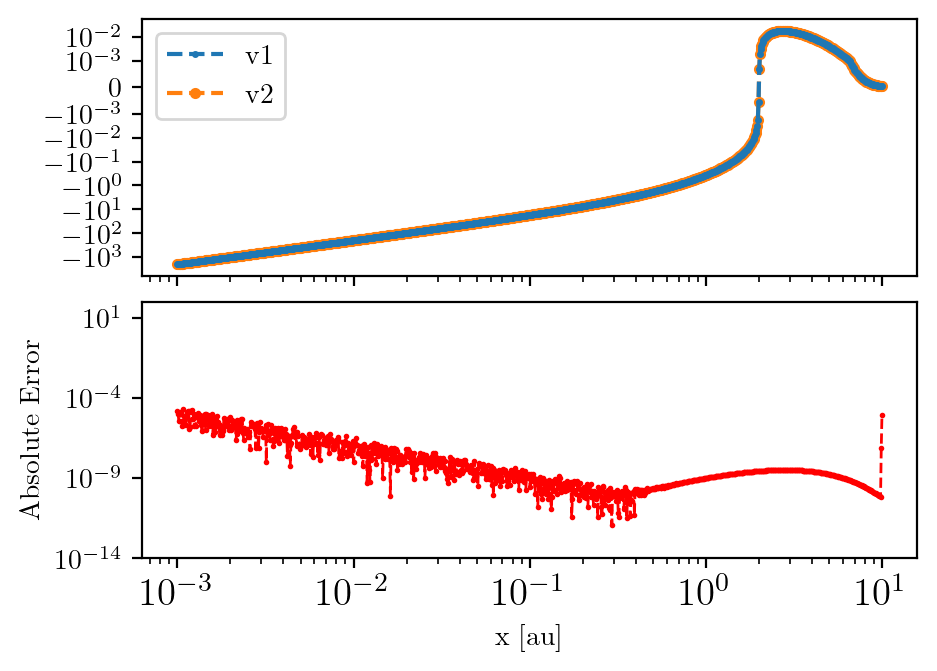

In [20]:
npa = NPA(Z, A, Ti_AU, Te_AU, rs, R, **npa_kwargs)
compare_over_grid(npa.grid.A_dfdx.dot(ρ), dρdx  )
compare_over_grid(npa.grid.A_d2fdx2.dot(ρ), d2ρdx2  )
compare_over_grid(npa.grid.A_laplace.dot(ρ), laplace_ρ  )

### Integrator Test

In [21]:
λ = 10
ρ = λ**-3/(8*π)/( 1  - np.exp(-R/λ)*(R/λ*(R/λ+2)/2 + 1 )) * np.exp(-npa.grid.xs/λ)
Q_at_r = lambda r: ( 1  - np.exp(-r/λ)*(r/λ*(r/λ+2)/2 + 1 ))/( 1  - np.exp(-R/λ)*(R/λ*(R/λ+2)/2 + 1 ))

In [22]:
Q_at_r(R), Q_list[-1], new_Q[-1]

(1.0, 0.999999997569223, 0.999999997569223)

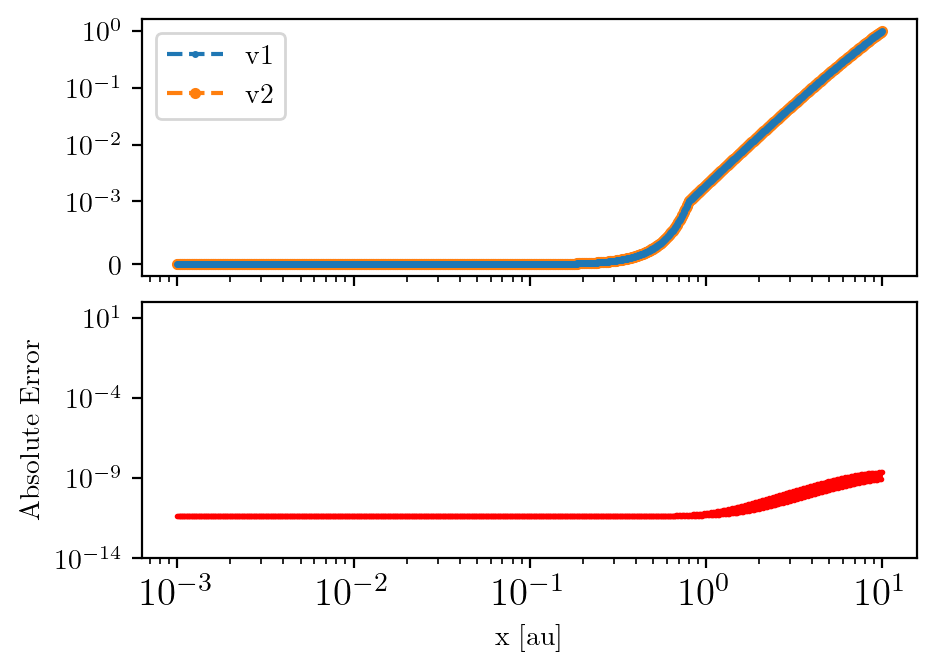

In [23]:
Q_list = [npa.grid.integrate_f(ρ, end_index=i) for i, xi in enumerate(npa.grid.xs)]# + [npa.grid.integrate_f(ρ)]
compare_over_grid( Q_list , Q_at_r(npa.grid.xs)  )

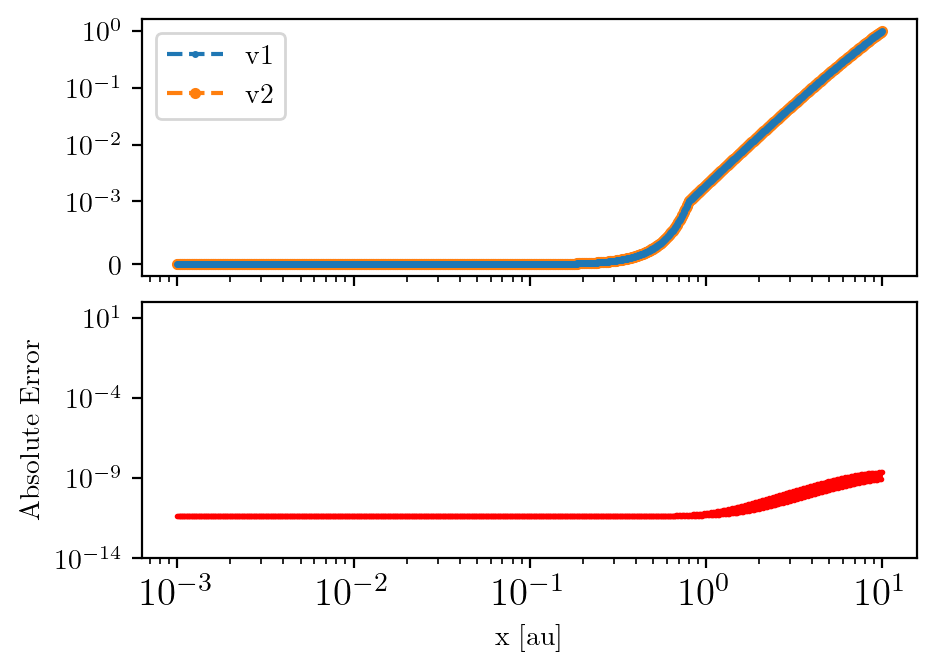

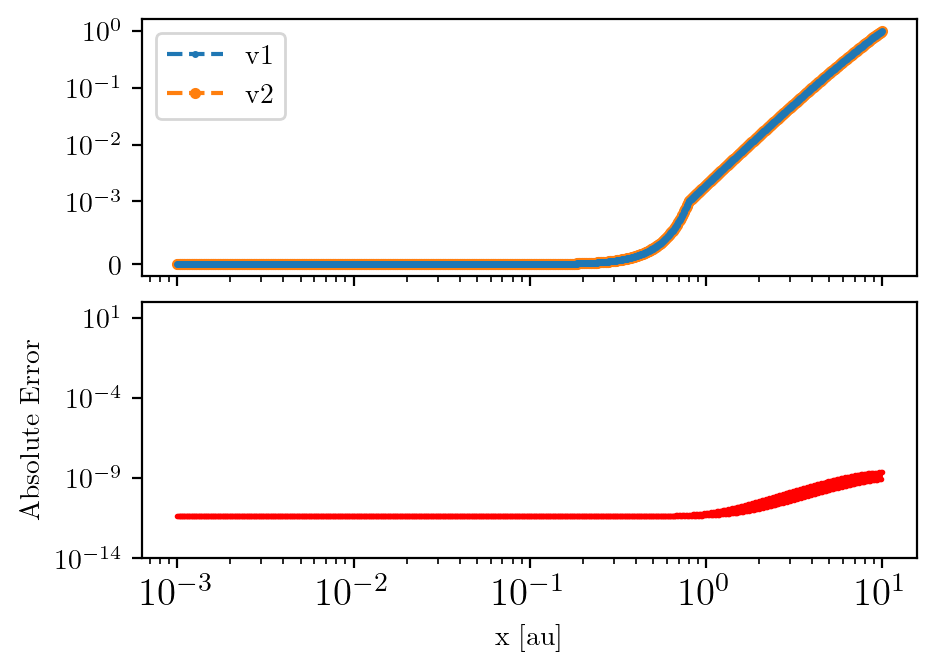

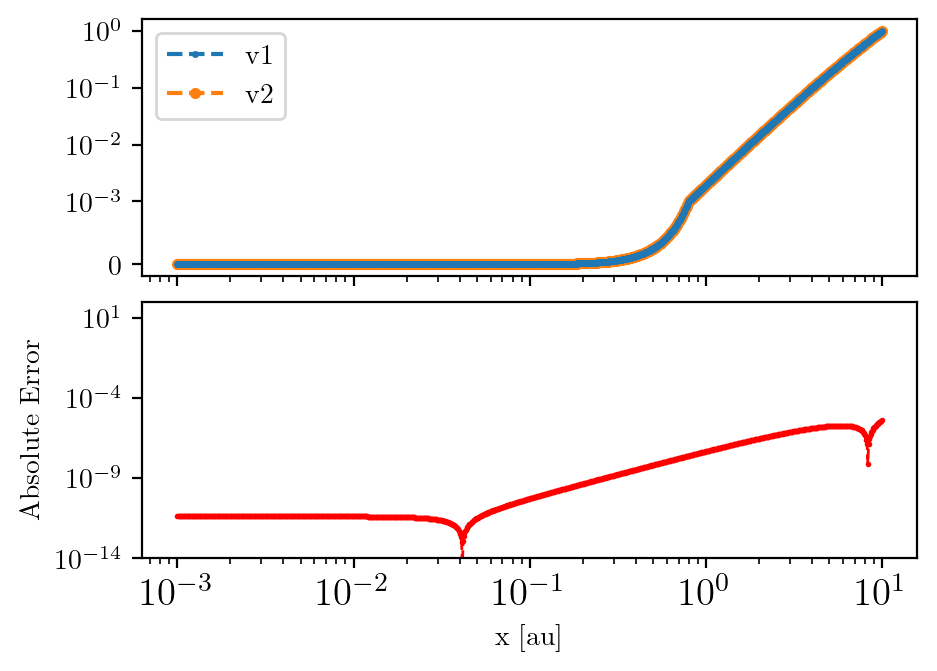

In [24]:
from scipy.integrate import quad, simpson, trapezoid, cumulative_trapezoid, romb
from scipy.interpolate import interp1d
# simpson( (ρ*npa.grid.xs**2*4*π)[:0], x=npa.grid.xs[:0])
new_Q = [ simpson( (ρ*npa.grid.xs**2*4*π)[:i], x=npa.grid.xs[:i]) for i in (list(range(1, len(npa.grid.xs)))+[None])   ] 
new2_Q = [ simpson( (ρ*npa.grid.xs**2*4*π)[:i], x=npa.grid.xs[:i]) for i in (list(range(1, len(npa.grid.xs)))+[None])   ] 
new3_Q = [ trapezoid( (ρ*npa.grid.xs**2*4*π)[:i], x=npa.grid.xs[:i]) for i in (list(range(1, len(npa.grid.xs)))+[None])   ] 
compare_over_grid( new_Q , Q_at_r(npa.grid.xs)  )
compare_over_grid( new2_Q , Q_at_r(npa.grid.xs)  )
compare_over_grid( new3_Q , Q_at_r(npa.grid.xs)  )


In [25]:
new2_Q[:5], new3_Q[:5]

([0.0,
  5.820220845085057e-14,
  1.1803495477169633e-13,
  1.79546484121897e-13,
  2.427830278977453e-13],
 [0.0,
  5.820220845085057e-14,
  1.1803662656612295e-13,
  1.7954902713695035e-13,
  2.427864665615729e-13])

In [11]:
new2_Q[-5:], new3_Q[-5:]

([0.9383727181446117,
  0.9534589020283321,
  0.9687573370948636,
  0.9842702814314183,
  0.999999997569223],
 [0.9383717994348941,
  0.9534579258958538,
  0.9687563023376617,
  0.984269185925895,
  0.9999988400443958])